# Using YOLO v3

Notebook to test a pre-trained YOLO on the COCO dataset and trying to apply to aerial images.

This notebook was made based on the tutorial avaiable on https://www.pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/

In [66]:
# import the necessary packages
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20.0, 15.0)

%matplotlib notebook

## Read Classes

In [2]:
# read the COCO class labels
labels_path = "./yolo-coco/coco.names"
LABELS = open(labels_path).read().strip().split("\n")

In [3]:
len(LABELS)

80

In [4]:
# list of colors to represent each class
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
                           dtype="uint8")

## Import Pre-Trained YOLO

In [5]:
# read weights and config from pre-trained YOLO
weights_path = "./yolo-coco/yolov3.weights"
config_path = "./yolo-coco/yolov3.cfg"
nn_model = cv2.dnn.readNetFromDarknet(config_path, weights_path)

In [6]:
nn_model.getLayerNames()

['conv_0',
 'bn_0',
 'relu_0',
 'conv_1',
 'bn_1',
 'relu_1',
 'conv_2',
 'bn_2',
 'relu_2',
 'conv_3',
 'bn_3',
 'relu_3',
 'shortcut_4',
 'conv_5',
 'bn_5',
 'relu_5',
 'conv_6',
 'bn_6',
 'relu_6',
 'conv_7',
 'bn_7',
 'relu_7',
 'shortcut_8',
 'conv_9',
 'bn_9',
 'relu_9',
 'conv_10',
 'bn_10',
 'relu_10',
 'shortcut_11',
 'conv_12',
 'bn_12',
 'relu_12',
 'conv_13',
 'bn_13',
 'relu_13',
 'conv_14',
 'bn_14',
 'relu_14',
 'shortcut_15',
 'conv_16',
 'bn_16',
 'relu_16',
 'conv_17',
 'bn_17',
 'relu_17',
 'shortcut_18',
 'conv_19',
 'bn_19',
 'relu_19',
 'conv_20',
 'bn_20',
 'relu_20',
 'shortcut_21',
 'conv_22',
 'bn_22',
 'relu_22',
 'conv_23',
 'bn_23',
 'relu_23',
 'shortcut_24',
 'conv_25',
 'bn_25',
 'relu_25',
 'conv_26',
 'bn_26',
 'relu_26',
 'shortcut_27',
 'conv_28',
 'bn_28',
 'relu_28',
 'conv_29',
 'bn_29',
 'relu_29',
 'shortcut_30',
 'conv_31',
 'bn_31',
 'relu_31',
 'conv_32',
 'bn_32',
 'relu_32',
 'shortcut_33',
 'conv_34',
 'bn_34',
 'relu_34',
 'conv_35',
 'bn

## Function to detect objects in image

In [98]:
def detect_objects_yolo(nn_model, image_path, threshold_boxes = 0.3, min_probability = 0.5):
    '''
        Function to apply a forward pass on YOLO NN and apply Non-Max Supression on the detected bounding boxes
        @param nn_model: trained YOLO model
        @param image_path: path string to download the image
        @param threshold_boxes: threshold to apply on non-max suppression
        @param min_probability: minimum probability to filter class and bounding boxes detections
    '''
    
    # Load Image
    image = cv2.imread(image_path)
    
    # Get Output Layers Names
    ln = nn_model.getUnconnectedOutLayersNames()
    
    # Create Blob image and set as input (resizing image to 416x416). 
    # Then, run the forward to identify classes and bounding boxes
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
                                 swapRB=True, crop=False)
    nn_model.setInput(blob)
    output_layers = nn_model.forward(ln)
    
    # For each output layer we have to identify each detection and filter them based on min_probability
    bounding_boxes = []
    class_confidences = []
    class_prediction_ids = []
    for output in output_layers:
        for detection in output:
            # First 5 params are for bounding box prediction
            # [center_x, center_y, width, height, bb_confidence, (classes_confidence)]
            class_scores = detection[5:]
            class_prediction_id = np.argmax(class_scores)
            class_confidence = class_scores[class_prediction_id]
            if detection[4] >= min_probability:
                # Use images size to find correct coordinates to draw the bounding boxes
                (image_height, image_width) = image.shape[:2]
                box = detection[0:4] * np.array([image_width, image_height, image_width, image_height])
                (centerX, centerY, width, height) = box.astype("int")
                
                # To draw the bounding boxes using OpenCV we have to get the top left coordinates
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                
                # Store values
                bounding_boxes.append([x, y, int(width), int(height)])
                class_confidences.append(float(class_confidence))
                class_prediction_ids.append(class_prediction_id)
                
    ## Apply Non-Max Supression in the bounding boxes
    indices = cv2.dnn.NMSBoxes(bounding_boxes, class_confidences, min_probability, threshold_boxes)
    
    if len(indices) > 0:
        for i in indices.flatten():
            (x, y, w, h) = (bounding_boxes[i][0], bounding_boxes[i][1], bounding_boxes[i][2], bounding_boxes[i][3])
            
            # Draw the detection on the image
            color = [int(c) for c in COLORS[class_prediction_ids[i]]]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            class_name = "{}: {:.4f}".format(LABELS[class_prediction_ids[i]], class_confidences[i])
            cv2.putText(image, class_name, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
    
    fig=plt.figure(image_path)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));
    

<IPython.core.display.Javascript object>


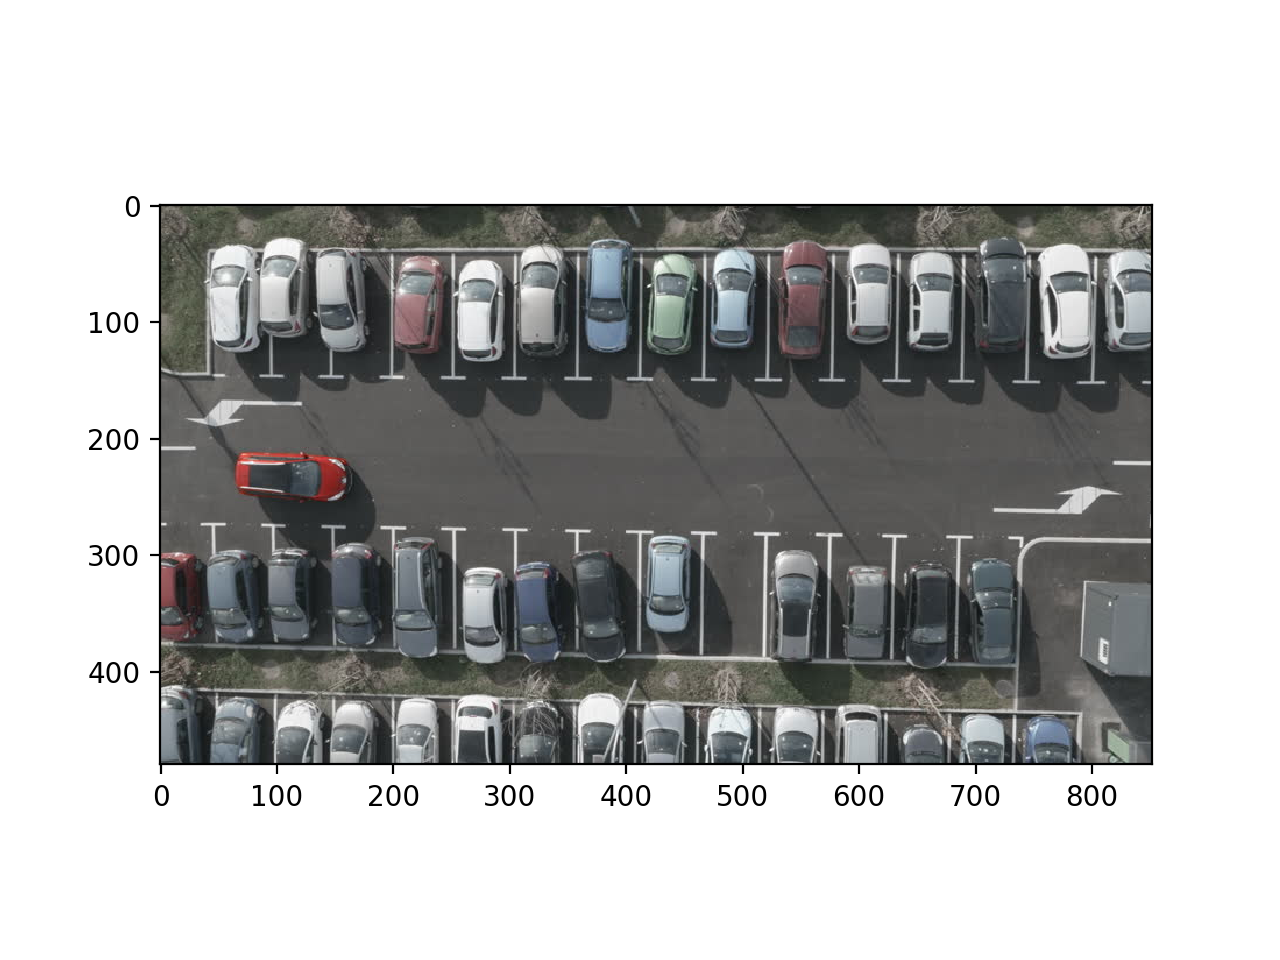

<IPython.core.display.Javascript object>


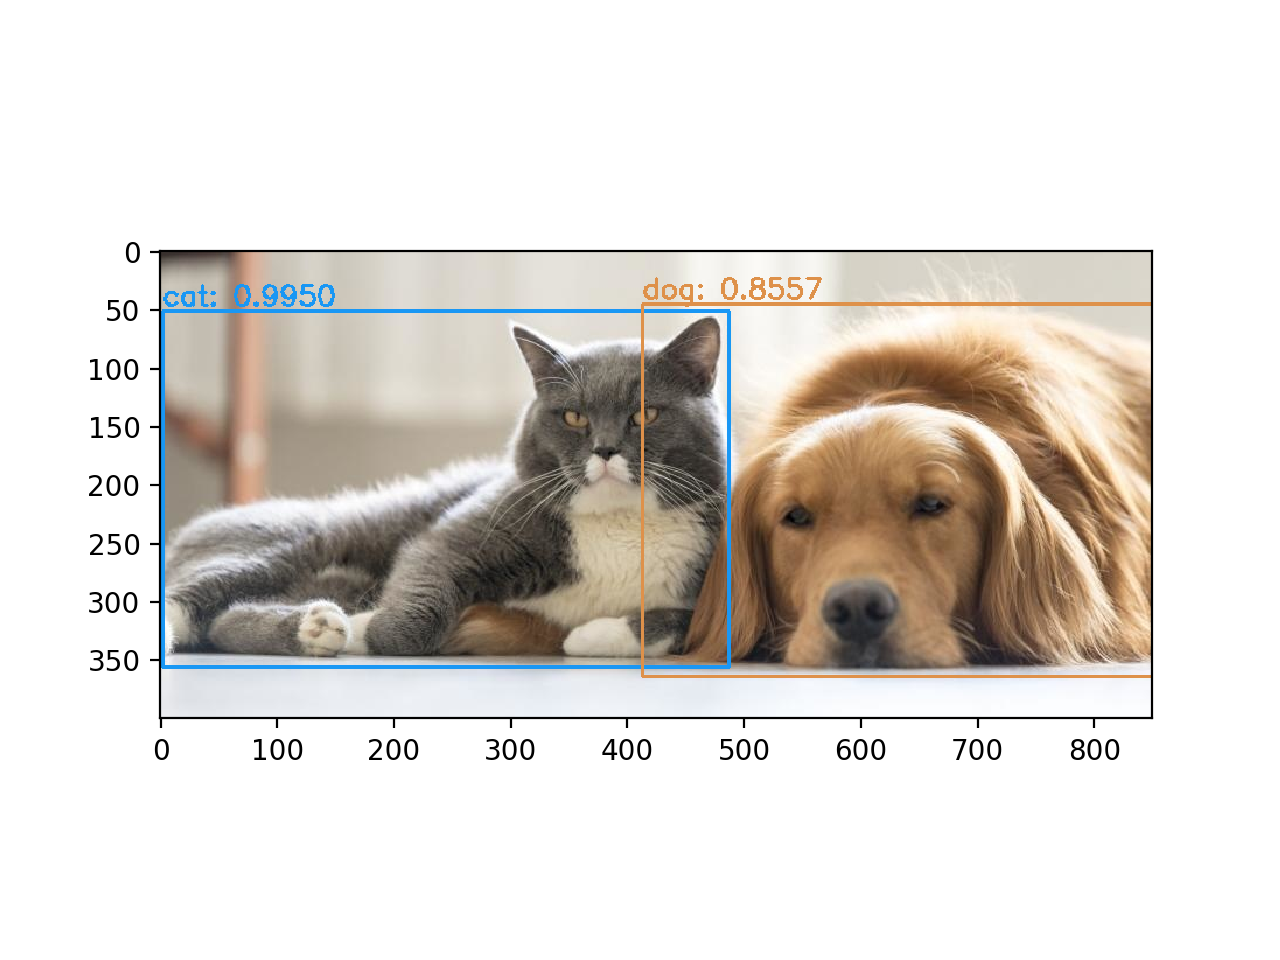

<IPython.core.display.Javascript object>


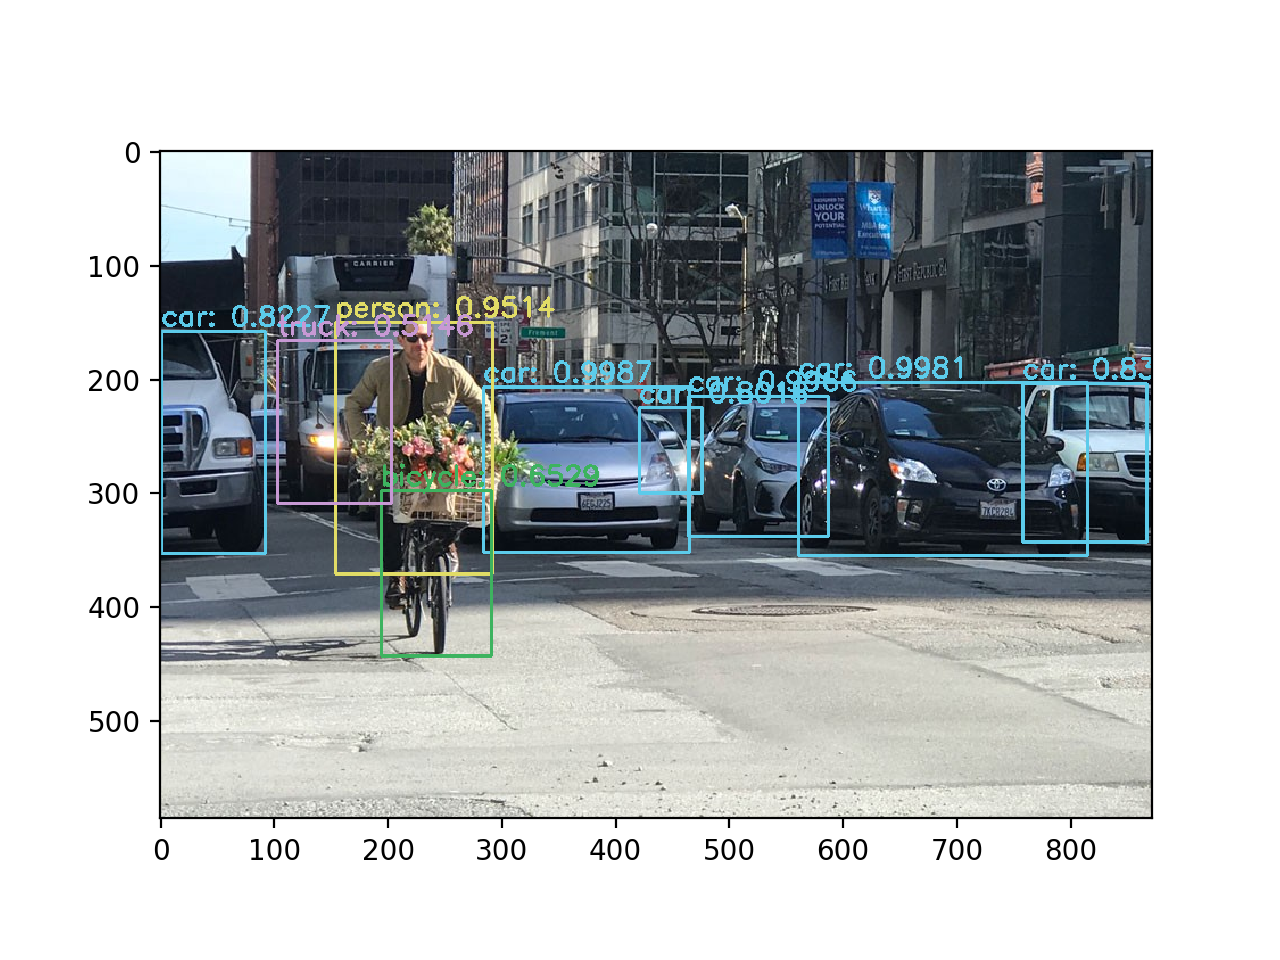

<IPython.core.display.Javascript object>


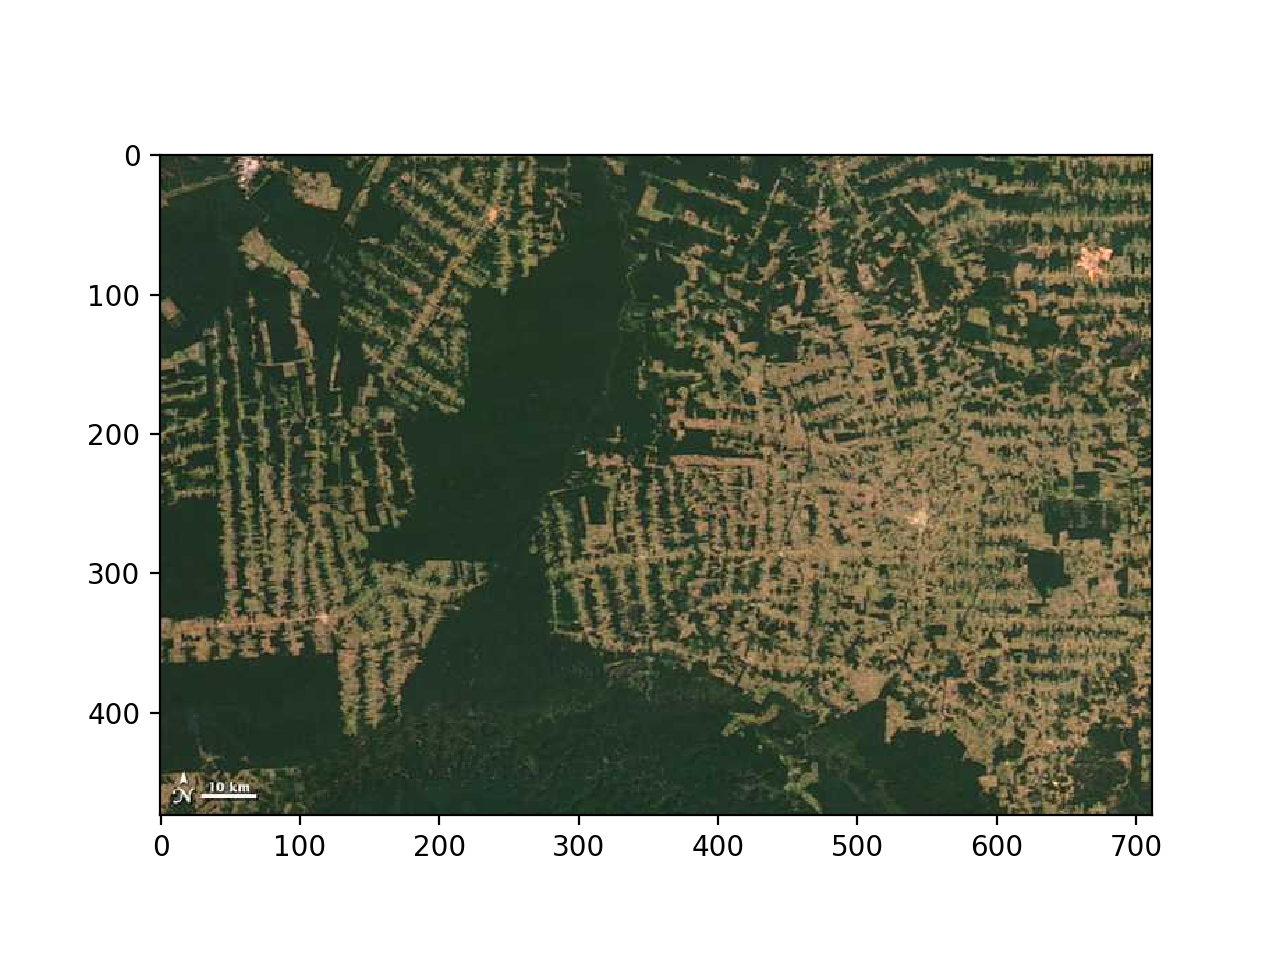

In [99]:
images_path = './images/'
for file in os.listdir(images_path):
    if file.endswith('.jpg') or file.endswith('.jpeg'):
        detect_objects_yolo(nn_model, images_path+file, threshold_boxes = 0.3, min_probability = 0.5)